# Benchmark convolutional model #11

Let's make a benchmark convolutional model and try to beat the previous 92.44% validation accuracy.



# Get the MNIST data

In [51]:
from common import get_mnist

mnist = get_mnist()

xtrain = mnist['x']['train']
xval = mnist['x']['val']

ytrain = mnist['y']['train']
yval = mnist['y']['val']

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Preprocessing

Let's:
* Reshape the input values to by (28,28) instead of (784,).
* Standardize the input values

In [55]:
xtrain = xtrain.reshape((55000,28,28,1))
xval = xval.reshape((5000,28,28,1))

xtrain = (xtrain - xtrain.mean()) / xtrain.std()
xval = (xval - xval.mean()) / xval.std()

# Model Architecture

[This](http://cs231n.github.io/convolutional-networks/) website suggests the following beginning architecture:

>* INPUT [32x32x3] will hold the raw pixel values of **the image**, in this case an image of width 32, height 32, and with three color channels R,G,B.
* CONV layer will compute the **output of neurons that are connected to local regions in the input**, each computing a dot product between their weights and a small region they are connected to in the input volume. This may result in volume such as [32x32x12] if we decided to use 12 **filters**.
* RELU layer will apply an **elementwise activation function, such as the max(0,x)** thresholding at zero. This leaves the size of the volume unchanged ([32x32x12]).
* POOL layer will perform a **downsampling** operation along the spatial dimensions (width, height), resulting in volume such as [16x16x12].
* FC (i.e. fully-connected) layer will **compute the class scores**, resulting in volume of size [1x1x10], where each of the 10 numbers correspond to a class score, such as among the 10 categories of CIFAR-10. As with ordinary Neural Networks and as the name implies, each neuron in this layer will be connected to all the numbers in the previous volume.

In [56]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
# config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [114]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, MaxPooling2D
from keras.regularizers import l2

convolutional = Sequential()

convolutional.add(
    Conv2D(
        input_shape=(28,28,1),
        filters=15,
        kernel_size=(3,3),
        strides=(1,1),
        padding='same',
        activation='relu',
        use_bias=True,
        # TODO: Regularizers
    )
)

convolutional.add(MaxPooling2D())

convolutional.add(Flatten())

convolutional.add(
    Dense(10,
          activation='softmax',
          input_shape=(28,28),
          kernel_regularizer=l2(0.00000001),
#           activity_regularizer=l2(0.0000000001)
         )
)

convolutional.compile(
    optimizer='rmsprop', # RMSprop | SGD | Adagrad | Adadelta | Adam | Adamax | Nadam
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

convolutional.fit(xtrain, ytrain, epochs=10, batch_size=250)

convolutional.evaluate(xval, yval)

Epoch 1/10
55000/55000 [==============================] - 4s 79us/step - loss: 0.3959 - acc: 0.8887
Epoch 2/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.1439 - acc: 0.9581
Epoch 3/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.1003 - acc: 0.9711
Epoch 4/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.0821 - acc: 0.9761
Epoch 5/10
55000/55000 [==============================] - 3s 48us/step - loss: 0.0692 - acc: 0.9798
Epoch 6/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.0615 - acc: 0.9819
Epoch 7/10
55000/55000 [==============================] - 3s 48us/step - loss: 0.0560 - acc: 0.9840
Epoch 8/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.0505 - acc: 0.9848
Epoch 9/10
55000/55000 [==============================] - 3s 47us/step - loss: 0.0473 - acc: 0.9857
Epoch 10/10
5000/5000 [==============================] - 1s 233us/step


[0.06306845534788445, 0.9832]

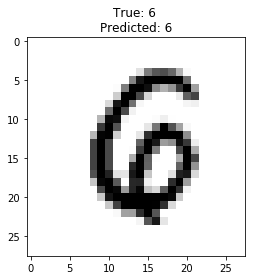

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

n=-10

ax = plt.imshow(xval[n].reshape((28,28)), cmap='binary')
true = yval[n].argmax()
predicted = convolutional.predict(xval[n].reshape((1,28,28,1))).argmax()
ax.axes.set_title('True: {} \nPredicted: {}'.format(true,predicted))

plt.tight_layout()

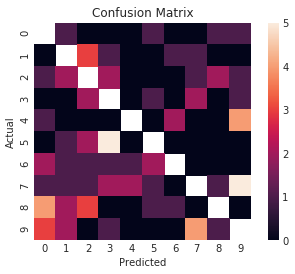

In [116]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns


ytrue = yval.argmax(axis=1)
ypred = convolutional.predict(xval).argmax(axis=1)

df = pd.DataFrame(confusion_matrix(y_true=ytrue, y_pred=ypred))
df = df[df < 400]
with sns.axes_style("white"):
    ax = sns.heatmap(df, square=True)
    ax.set(title='Confusion Matrix', xlabel='Predicted', ylabel='Actual')

~~Our model tends to confuse 9's and 7's, and sometimes a 2 looks like an 8, or a 5 will look like a 3.~~

Actually, these confusion matrices seem to be rather unstable. I ran a slightly tuned model and they changed significantly, although I do notice that 7's and 9's are still confused for each other. Some are common, but for example this model doesn't confuse 2's for 8's.

In [119]:
xval[ytrue != ypred].shape

(84, 28, 28, 1)

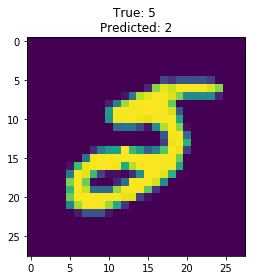

In [131]:
n = 10
ax = plt.imshow(xval[ytrue != ypred].reshape((84,28,28))[n])
true = ytrue[ytrue != ypred][n]
pred = ypred[ytrue != ypred][n]
ax.axes.set_title('True: {} \nPredicted: {}'.format(true, pred))

plt.tight_layout()

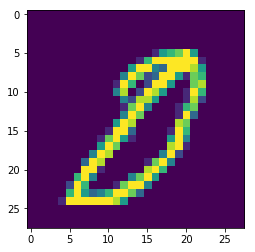

In [169]:
import numpy as np
plt.imshow(xval[convolutional.predict(xval).max(axis=1).argsort()].reshape((5000,28,28))[10])